In [0]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

import os
import pathlib
import time
import gc

# IMG_SIZE = (200, 200)
# IMG_SIZE = (300, 300)
IMG_SIZE = (400, 400)
INPUT_SIZE = tuple(list(IMG_SIZE) + [3])


In [0]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

--2019-08-02 04:04:04--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  20.9MB/s    in 40s     

2019-08-02 04:04:44 (19.1 MB/s) - ‘images.tar’ saved [793579520/793579520]



In [0]:
!tar -xf images.tar

In [0]:
from google.colab import drive
drive.mount("drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
!ls "./"
dataFolder = "./Images/"
mydrive = "./drive/My Drive/colab_data/dog_breed/"
dataFiles = [mydrive + "data/" + file for file in ("train.csv", "test.csv")]

drive  Images  images.tar  sample_data


# 1. Stratified split the images into train and test.

In [0]:
#----------------------------------------------------------------------------
class Prepare_train_test:
  """
  Make the correspondance between the images and labels (breeds of dogs),
  and stratified split the data into train and test parts.
  """
  def __init__(self, data_root, test_size, random_seed=42, saveFiles=None):
    """
    Then files in "data_root" will be stratified split into train and test parts.
    
    # Arguments
      -"data_root": the folder name of the images of dogs.
      -"test_size": the ratio of the test size to the total size.
      -"random_seed=42": the random seed for the stratified split.
      -"saveFiles=None": 
        the list of file names (including path) to save train and test dfs 
        if it is given and "loadFiles==None". 
        If "loadFiles" is not None, this argument plays no role. 
    """
    self.data_root = pathlib.Path(data_root)

    # dictionary of breeds and labels
    breeds = [item.name for item in self.data_root.iterdir()]
    breeds.sort()
    # the correspondance between the breeds and labels
    self.breeds_labels = dict((item,i) for (i, item) in enumerate(breeds))
    self.breeds = breeds # list of breeds 
    
    images_labels = [[str(image), image.parent.name, self.breeds_labels[image.parent.name], ] 
                     for image in self.data_root.glob("*/*.jpg")]
    # labels = np.array([self.breeds_labels[image] for image in images])
    images_lables = pd.DataFrame(images_labels, columns=["image", "breed", "label"])

    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_seed)
    # stratified split
    for train_index, test_index in split.split(images_lables, images_lables["label"]):
      self.train = images_lables.loc[train_index] 
      self.test = images_lables.loc[test_index]
    
    # save
    if saveFiles:
      self.train.to_csv(saveFiles[0], index=None)
      self.test.to_csv(saveFiles[1], index=None)

    # load images
    # print("Load images")
    # self.load_images()
    
  def load_images(self):
    """
    load and convert the images into np.array.
    !!!Do not run it. Otherwise RAM will collapse!
    """
    x_list = []
    for df in (self.train, self.test):
      #images = [img_to_array(load_img(image_file, target_size=IMG_SIZE))/255. for image_file in df.iloc[:,0]]
      #images = np.stack(images, axis=0)
      
      print(len(df))
      
      # first image
      images = np.expand_dims(img_to_array(load_img(df.iloc[0,0], target_size=IMG_SIZE))/255., axis=0)
      # other image
      for i in range(1, len(df)):
        if i%1000 == 0: print(i)
        temp = np.expand_dims(img_to_array(load_img(df.iloc[i,0], target_size=IMG_SIZE))/255., axis=0)
        images = np.vstack((images, temp))
            
      x_list.append(images)
    
    # get the arrays of images
    self.x_train, self.x_test = x_list
    # get the labels
    self.y_train = self.train.iloc[:, 2].values
    self.y_train = self.test.values[:, 2].values

#----------------------------------------------------------------------------
class Load_train_test:
  """
  Load the train and test data 
  """
  def __init__(self, files):
    """
    Load the data from "files".
    
    # Arguments
      -"files": the list of the files of train and test data, [train.csv, test.csv]
        And each file should include three columns, ["image", "breed", "label"].
    """
    self.train = pd.read_csv(files[0], index_col=None)
    self.test = pd.read_csv(files[1], index_col=None)
    self.breeds_labels = dict(self.train.groupby(["breed", "label"]).groups.keys())
    self.breeds = list(self.breeds_labels.keys())
    self.breeds.sort(key = lambda x: self.breeds_labels[x])

## 1.1  Train and test images data

In [0]:
# Make the train and test data
# images_labels = Prepare_train_test(dataFolder, 0.1, saveFiles=dataFiles)
# load the trian and test data
images_labels = Load_train_test(files=dataFiles)

#2. ImageDataGenerator

In [0]:
# generator for train and validation data
datagen = ImageDataGenerator(rescale=1./255, 
                             rotation_range=40, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             channel_shift_range=10,
                             horizontal_flip=True, 
                             validation_split=0.1)
# generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

## 2.1 Generators Exploration.

In [0]:
# ......

## 2.2 Data generators (train, validation, test)

In [0]:
# BATCH_SIZE_train = 500
BATCH_SIZE_train = 100
BATCH_SIZE_val = 98
BATCH_SIZE_test = 42

train_generator = datagen.flow_from_dataframe(dataframe=images_labels.train, x_col="image", y_col="breed", 
                                              subset="training", 
                                              classes=images_labels.breeds, 
                                              class_mode="sparse", 
                                              batch_size=BATCH_SIZE_train, 
                                              target_size=IMG_SIZE)
val_generator = datagen.flow_from_dataframe(dataframe=images_labels.train, x_col="image", y_col="breed", 
                                            subset="validation", 
                                            classes=images_labels.breeds, 
                                            class_mode="sparse", 
                                            batch_size=BATCH_SIZE_val, 
                                            target_size=IMG_SIZE)

test_generator = test_datagen.flow_from_dataframe(dataframe=images_labels.test, x_col="image", y_col="breed", 
                                                  classes=images_labels.breeds, 
                                                  class_mode="sparse", 
                                                  batch_size=BATCH_SIZE_test, 
                                                  target_size=IMG_SIZE, 
                                                  shuffle=False)

Found 16670 validated image filenames belonging to 120 classes.
Found 1852 validated image filenames belonging to 120 classes.
Found 2058 validated image filenames belonging to 120 classes.


In [0]:
for i, breed in enumerate(images_labels.breeds):
  if (train_generator.class_indices[breed] != i): 
    print("Wrong!")
    break
else:
  print("Yes!")

Yes!


In [0]:
for i, breed in enumerate(images_labels.breeds):
  if (val_generator.class_indices[breed] != i): 
    print("Wrong!")
    break
else:
  print("Yes!")

Yes!


# 3. Construct model


In [0]:
# function to construct model
def fModel_dog_breeds(base_model, flat_layers):
  """
  -"flat_layers": the list of units in the flat layers top of "base_model". 
    It should not incleude the output layer which is fixed to be 120.
  """
  myL2 = 1e-3
  model = tf.keras.Sequential()
  model.add(base_model)
  model.add(layers.Flatten())
  for n_units in flat_layers:
    model.add(layers.Dense(units=n_units, activation="relu"
                           # kernel_regularizer=keras.regularizers.l2(myL2), 
                           #bias_regularizer=keras.regularizers.l2(myL2)
                          ))
    model.add(layers.Dropout(0.5))
  model.add(layers.Dense(120, activation="softmax"))
  
  return model


In [0]:
# import InceptionV3
from tensorflow.keras.applications import InceptionV3
conv_base = InceptionV3(include_top=False, weights="imagenet", input_shape=INPUT_SIZE)

W0802 04:05:49.899074 140491995563904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


87916544/87910968 [==============================] - 3s 0us/step


In [0]:
model = fModel_dog_breeds(conv_base, [1204])
print("Number of trainalbe layers before freezing the base model:", len(model.trainable_weights))
conv_base.trainable = False
print("Number of trainalbe layers after freezing the base model:", len(model.trainable_weights))

Number of trainalbe layers before freezing the base model: 192
Number of trainalbe layers after freezing the base model: 4


## 3.1 One Cycle Policy

In [0]:
import math

class OneCyclePolicy(keras.callbacks.Callback):
  """
  To implement the one cycle policy to find a good learning rate.
  """
  def __init__(self, init_lr, final_lr, num, beta=0.98):
    """
    -"init_lr": the initial learning rate to tested
    -"final_lr": the final learning rate to tested
    -"num": the number of learing rates to be tested. 
      Usually, it should be "len(train_data)/batch_size" or "steps_per_epoch". 
    """
    # call the super init
    keras.callbacks.Callback.__init__(self)
    self.init_lr, self.final_lr, self.num, self.beta = init_lr, final_lr, num, beta
    
    # calculate the multiplication factor
    self.mult = (self.final_lr/self.init_lr)**(1./self.num)
    
    self.losses = []
    self.log_lrs = []
    self.best_loss = None
    self.avg_loss = 0
    
  def on_train_begin(self, logs={}):
    # set the inital learning rate
    K.set_value(self.model.optimizer.lr, self.init_lr)
  
  def on_train_batch_end(self, batch, logs={}):
    
    # get the average loss
    current = logs.get("loss")
    # update the average loss
    self.avg_loss = self.beta*self.avg_loss + (1-self.beta)*current
    # get the smoothed (bias corrrected) loss 
    smoothed  = self.avg_loss/(1 - self.beta**(batch+1))
    
    # update the best loss
    if self.best_loss is None or self.best_loss > smoothed:
      self.best_loss = smoothed

    if 2*self.best_loss < smoothed :
      self.model.stop_training = True
    else:
      # append the smoothed loss and the log lr
      self.losses.append(smoothed)
      # append log10 lr
      lr = K.get_value(self.model.optimizer.lr)
      self.log_lrs.append(math.log10(lr))
      # update lr
      K.set_value(self.model.optimizer.lr, lr*self.mult)


In [0]:
model.compile(optimizer = keras.optimizers.RMSprop(lr=1e-3), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
find_lr = OneCyclePolicy(1e-7, 1e-3, train_generator.n//BATCH_SIZE_train)
history = model.fit_generator(train_generator, epochs=1, steps_per_epoch=train_generator.n//BATCH_SIZE_train,
                              callbacks=[find_lr])

92/92 [==============================] - 759s 8s/step - loss: 6.5364 - acc: 0.0294


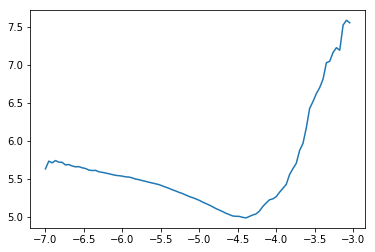

In [0]:
# for IMG_SIZE=[400,400], batch_size=180 and with flat kernel and no regularizers (l2=1e-4)
n=92
plt.plot(find_lr.log_lrs[:n], find_lr.losses[:n])
plt.show()

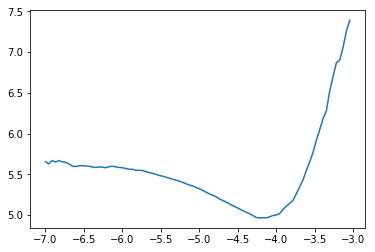

In [0]:
# for IMG_SIZE=[300,300], batch_size=180 and with flat kernel and no regularizers (l2=1e-4)
n=92
plt.plot(find_lr.log_lrs[:n], find_lr.losses[:n])
plt.show()

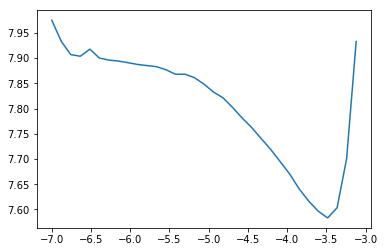

In [0]:
# for batch_size=500 and with flat kernel and bias regularizers (l2=1e-4)
n=33
plt.plot(find_lr.log_lrs[:n], find_lr.losses[:n])
plt.show()

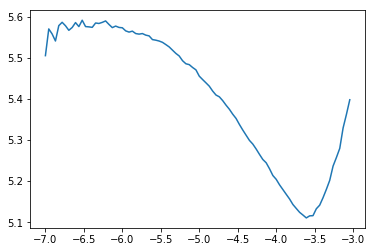

In [0]:
# for batch_size=180 and no regularizer
n=92
plt.plot(find_lr.log_lrs[:n], find_lr.losses[:n])
plt.show()

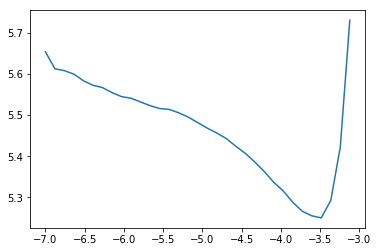

In [0]:
# for batch_size=500 and regularizer
"""
n=33
plt.plot(find_lr.log_lrs[:n], find_lr.losses[:n])
plt.show()
"""

## 3.2 Train and test

In [0]:

from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
# checkpoints
modelFolder = "./models/"
bestModelFile = modelFolder + "weights.epoch:{epoch:02d}-val_acc:{val_acc:0.3f}.h5"

checkpoint_bestmodel = ModelCheckpoint(bestModelFile, monitor="val_acc", save_weight_only=True, save_best_only=True)


# checkpoint_finalmodel = LambdaCallback(on_train_end=lambda logs: 
#                                       model.save_weights(bestModelFile.format(epoch=EPOCHS, val_acc=logs["val_acc"])))

callback_list = [checkpoint_bestmodel]

In [0]:
!mkdir "./models"
!ls 

drive  Images  images.tar  models  sample_data


In [0]:
# learning_rate = 1e-4
# learning_rate = 3e-5 # one-cycle policy for IMG_SIZE=[200, 200]
learning_rate = 1e-5 # one-cycle policy for IMG_SIZE=[300, 300], IMG_SIZE=[400, 400]

model.compile(optimizer = keras.optimizers.RMSprop(lr=learning_rate), loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
EPOCHS = 40
history = model.fit_generator(train_generator, epochs=EPOCHS, steps_per_epoch=train_generator.n//BATCH_SIZE_train, 
                              validation_data=val_generator, validation_steps=val_generator.n//BATCH_SIZE_val, 
                              callbacks=callback_list )
finalModel = bestModelFile.format(epoch=EPOCHS, val_acc=history.history["val_acc"][-1])
if not os.path.exists(finalModel):
  model.save_weights(finalModel)

Epoch 1/40
166/166 [==============================] - 874s 5s/step - loss: 3.0000 - acc: 0.3485 - val_loss: 1.1983 - val_acc: 0.7460
Epoch 2/40
166/166 [==============================] - 898s 5s/step - loss: 1.5026 - acc: 0.6237 - val_loss: 0.7884 - val_acc: 0.8005
Epoch 3/40
166/166 [==============================] - 897s 5s/step - loss: 1.2161 - acc: 0.6850 - val_loss: 0.6799 - val_acc: 0.8067
Epoch 4/40
166/166 [==============================] - 908s 5s/step - loss: 1.0963 - acc: 0.7141 - val_loss: 0.6389 - val_acc: 0.8163
Epoch 5/40
166/166 [==============================] - 920s 6s/step - loss: 1.0180 - acc: 0.7327 - val_loss: 0.6175 - val_acc: 0.8152
Epoch 6/40
166/166 [==============================] - 919s 6s/step - loss: 0.9705 - acc: 0.7424 - val_loss: 0.6287 - val_acc: 0.8231
Epoch 7/40
166/166 [==============================] - 921s 6s/step - loss: 0.9316 - acc: 0.7517 - val_loss: 0.5937 - val_acc: 0.8237
Epoch 8/40
166/166 [==============================] - 1022s 6s/step -

In [0]:
test_generator.reset()
model.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE_test)

[0.2839274158587261, 0.91739553]

In [0]:
model1 = keras.models.load_model("models/weights.epoch:36-val_acc:0.855.h5")
# model2 = keras.models.load_model("drive/My Drive/colab_data/dog_breed/models/weights.epoch:45-val_acc:0.599206.h5")

W0802 14:23:59.399945 140491995563904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0802 14:23:59.403798 140491995563904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0802 14:23:59.412644 140491995563904 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

In [0]:
test_generator.reset()
model1.evaluate_generator(test_generator, steps=test_generator.n//BATCH_SIZE_test)

[0.28793709025699266, 0.9139942]

In [0]:
!cp models/weights.epoch:40-val_acc:0.837.h5 "./drive/My Drive/colab_data/dog_breed/models/"